In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd

from pysabr import Hagan2002LognormalSABR

import yfinance as yf
spx = yf.Ticker("^SPX")

current_price = spx.info["regularMarketPrice"]

df = pd.concat([spx.option_chain(x).calls for x in spx.options])
df['contractSymbol'] = dates_numeric = df['contractSymbol'].str.replace(r"[a-zA-Z]", '').map(lambda x: str(x)[:-8])
df['contractSymbol'] = pd.to_datetime(df['contractSymbol'], format='%y%m%d')

maturities = df['contractSymbol'].unique()

C:\Users\somig\AppData\Local\Temp/ipykernel_16496/3821264098.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df['contractSymbol'] = dates_numeric = df['contractSymbol'].str.replace(r"[a-zA-Z]", '').map(lambda x: str(x)[:-8])


In [4]:
import time
import datetime

current_time = time.localtime()

def delta_t(m):

    now = pd.to_datetime(time.strftime('%Y-%m-%d %H:%M:%S', current_time))
    delta_t = m - now
    year_dt = datetime.timedelta(365,0,0,0)

    return round(delta_t/year_dt, 6)


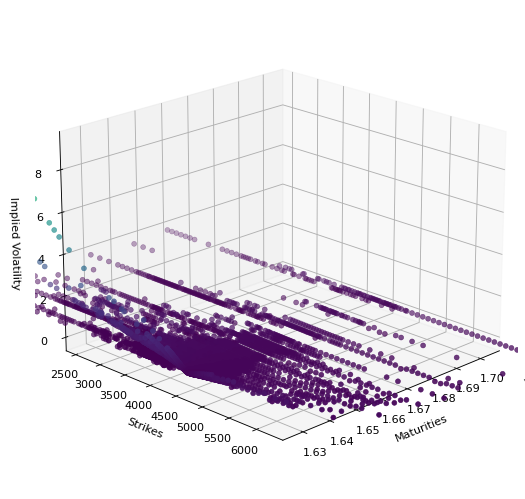

In [5]:
# 3d surface plot

polished_df = df[df["strike"] >= 3500]
polished_df = polished_df[polished_df["strike"] <= 5700]

x = pd.to_numeric(df["contractSymbol"])
y = df["strike"]
z = df["impliedVolatility"]


def plot3d(x, y, z, rng=current_price, scatter=True):
    fig = plt.figure(figsize=(15, 8), dpi=80)

    ax = plt.axes(projection='3d')
    if scatter:
        ax.scatter(x, y, z, c=z, cmap='viridis', linewidth=.5)
    else:
        ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='none');



    ax.set_xlabel('Maturities')
    ax.set_ylabel('Strikes')
    ax.set_zlabel('Implied Volatility')

    ax.set_ylim((current_price - rng, current_price + rng))
    
    ax.invert_xaxis()
    ax.view_init(20, 45)
    

    plt.show()

plot3d(x, y, z, 2000)  

In [6]:
#2d volatility smiles

def plot2d(x, y):
    fig = plt.figure(figsize=(6, 4), dpi=80)
    ax = fig.gca()

    ax.plot(x, y)

    ax.set_xlabel('Strikes')
    ax.set_ylabel('Implied Volatility')
    ax.set_xbound(4000, 6000)

    plt.show()


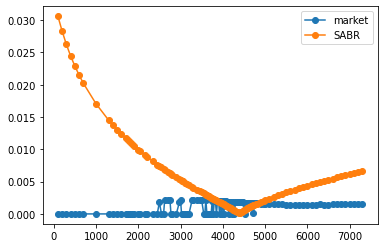

In [50]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

#volatility smile

maturity = maturities[-1]
option = df[df["contractSymbol"] == maturity]
dt = delta_t(pd.to_datetime(maturity))

strikes = option["strike"]
fwd = current_price
expiryTime = dt
marketVols = option["impliedVolatility"]*10**-2

x0 = [0.1] * 4
def f(params):
    vols = np.array([
        ql.sabrVolatility(strike, fwd, expiryTime, *x0)
        for strike in strikes
    ])
    return ((vols - np.array(marketVols))**2 ).mean() **.5

cons=(
    {'type': 'ineq', 'fun': lambda x:  0.99 - x[1]},
    {'type': 'ineq', 'fun': lambda x: x[1]},    
    {'type': 'ineq', 'fun': lambda x: x[3]}
)

result = minimize(f, x0, constraints=cons)
X = result['x']

newVols = [ql.sabrVolatility(strike, fwd, expiryTime, *X) for strike in strikes]
plt.plot(strikes, marketVols, marker='o', label="market")
plt.plot(strikes, newVols, marker='o', label="SABR")
plt.legend();



In [ ]:
import barchart as bc